Initial Imports

In [2]:
import h2o
from h2o.automl import H2OAutoML
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from h2o.estimators import H2ODeepLearningEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
from datetime import datetime

# Server Start

In [3]:
h2o.init()

  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Madrid
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,4 months and 30 days
H2O_cluster_name:,H2O_from_python_markel_plz9dd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.857 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


## Training of the initial basic model

In [4]:
def load_and_prepare_data(file_path):
    df = pd.read_csv(file_path)
    df.columns = df.columns.str.strip()
    df['Label_Binary'] = df['Label'].apply(lambda x: 'BENIGN' if x == 'BENIGN' else 'ATTACK')
    
    # Convertir 'Timestamp' a datetime y ordenar
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df = df.sort_values(by='Timestamp')
    
    # Forzar 'Label_Binary' como categoría
    df['Label_Binary'] = df['Label_Binary'].astype('category')
    
    h2o_frame = h2o.H2OFrame(df)

    # Asegurarse de que las columnas sean categóricas donde sea necesario
    h2o_frame['Label_Binary'] = h2o_frame['Label_Binary'].asfactor()

    return h2o_frame


In [5]:
mon_tues_array = [
    "CICIDS2017/Monday-WorkingHours.pcap_ISCX.csv",
    "CICIDS2017/Tuesday-WorkingHours.pcap_ISCX.csv"
]
mon_tues_frames = [load_and_prepare_data(file) for file in mon_tues_array]
mon_tues = mon_tues_frames[0].rbind(mon_tues_frames[1])

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
wed = load_and_prepare_data("CICIDS2017/Wednesday-workingHours.pcap_ISCX.csv")


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
# Lista de predictores y respuesta
predictors = [
    #"Destination Port", 
    "Protocol","Flow Duration", "Total Fwd Packets", 
    "Total Backward Packets", "Total Length of Fwd Packets", 
    "Total Length of Bwd Packets", "Fwd Packet Length Max", 
    "Fwd Packet Length Min", "Fwd Packet Length Mean", "Fwd Packet Length Std", 
    "Bwd Packet Length Max", "Bwd Packet Length Min", "Bwd Packet Length Mean", 
    "Bwd Packet Length Std", "Flow Bytes/s", "Flow Packets/s", "Flow IAT Mean", 
    "Flow IAT Std", "Flow IAT Max", "Flow IAT Min", "Fwd IAT Total", 
    "Fwd IAT Mean", "Fwd IAT Std", "Fwd IAT Max", "Fwd IAT Min", 
    "Bwd IAT Total", "Bwd IAT Mean", "Bwd IAT Std", "Bwd IAT Max", 
    "Bwd IAT Min", "Fwd PSH Flags", "Bwd PSH Flags", "Fwd URG Flags", 
    "Bwd URG Flags", "Fwd Header Length", "Bwd Header Length", 
    "Fwd Packets/s", "Bwd Packets/s", "Min Packet Length", "Max Packet Length", 
    "Packet Length Mean", "Packet Length Std", "Packet Length Variance", 
    "FIN Flag Count", "SYN Flag Count", "RST Flag Count", "PSH Flag Count", 
    "ACK Flag Count", "URG Flag Count", "CWE Flag Count", "ECE Flag Count", 
    "Down/Up Ratio", "Average Packet Size", "Avg Fwd Segment Size", 
    "Avg Bwd Segment Size", "Fwd Header Length", "Fwd Avg Bytes/Bulk", 
    "Fwd Avg Packets/Bulk", "Fwd Avg Bulk Rate", "Bwd Avg Bytes/Bulk", 
    "Bwd Avg Packets/Bulk", "Bwd Avg Bulk Rate", "Subflow Fwd Packets", 
    "Subflow Fwd Bytes", "Subflow Bwd Packets", "Subflow Bwd Bytes", 
    "Init_Win_bytes_forward", "Init_Win_bytes_backward", "act_data_pkt_fwd", 
    "min_seg_size_forward", "Active Mean", "Active Std", "Active Max", 
    "Active Min", "Idle Mean", "Idle Std", "Idle Max", "Idle Min"
]

response = "Label"
response_binary = "Label_Binary"

In [ ]:
def train_automl(train, valid=None, max_runtime_secs=60):
    aml = H2OAutoML(max_runtime_secs=max_runtime_secs, seed=1234, verbosity="info", nfolds=0, keep_cross_validation_predictions=False,
                        )
    aml.train(x=predictors, y=response, training_frame=train, validation_frame=valid)
    return aml


In [ ]:
#TODO: retrainment has to be smooth
def train_binary(train, valid=None, max_runtime_secs=60, checkpoint_model=None):
    if checkpoint_model is None:
        aml = H2OAutoML(max_runtime_secs=max_runtime_secs, seed=1234, verbosity="info", nfolds=0, keep_cross_validation_predictions=False
                    )
        aml.train(x=predictors, y=response_binary, training_frame=train, validation_frame=valid)
        new_model = aml.leader
    else:
        if checkpoint_model.algo == "DeepLearning":
            new_model = H2ODeepLearningEstimator(
                model_id="best_model_DL_" + str(checkpoint_model.params['epochs']['actual'] + 1),
                checkpoint=checkpoint_model.model_id,
                epochs=int(checkpoint_model.params['epochs']['actual']) + 5,
                seed=checkpoint_model.params['seed']['actual']
            )
        elif checkpoint_model.algo == "drf":
            new_model = H2ORandomForestEstimator(
                model_id="best_model_forest_" + str(checkpoint_model.params['ntrees']['actual'] + 1),
                checkpoint=checkpoint_model.model_id,
                ntrees=int(checkpoint_model.params['ntrees']['actual']) + 5,
                seed=checkpoint_model.params['seed']['actual']
            )
        # Entrenar con el conjunto de entrenamiento completo
        new_model.train(x=predictors, y=response_binary, training_frame=train)
    return new_model

In [ ]:
def model_metrics_evaluation(model_predictions, ground_truth, label='ATTACK'):
    accuracy = accuracy_score(ground_truth.as_data_frame(), model_predictions.as_data_frame())
    f1 = f1_score(ground_truth.as_data_frame(), model_predictions.as_data_frame(), pos_label=label)
    recall = recall_score(ground_truth.as_data_frame(), model_predictions.as_data_frame(), pos_label=label)
    precision = precision_score(ground_truth.as_data_frame(), model_predictions.as_data_frame(), pos_label=label)
    confusion = confusion_matrix(ground_truth.as_data_frame(), model_predictions.as_data_frame(), labels=['BENIGN', 'ATTACK'])
    return accuracy, f1, recall, precision, confusion

### Pipeline

In [ ]:

#Binary clasification
model = train_binary(mon_tues)
print(model)

AutoML progress: |
11:45:12.756: Project: AutoML_4_20240813_114512
11:45:12.756: Cross-validation disabled by user: no fold column nor nfolds > 1.
11:45:12.756: Setting stopping tolerance adaptively based on the training frame: 0.00101231013475982
11:45:12.756: Build control seed: 1234
11:45:12.756: Since cross-validation is disabled, and validation frame(s) were not provided, automatically split the training data into training, validation frame(s) in the ratio 90/10/0.
11:45:14.494: training frame: Frame key: AutoML_4_20240813_114512_training_py_260_sid_a22e    cols: 86    rows: 878297  chunks: 120    size: 319111011  checksum: 2104673652179994608
11:45:14.530: validation frame: Frame key: AutoML_4_20240813_114512_validation_py_260_sid_a22e    cols: 86    rows: 97530  chunks: 120    size: 86641026  checksum: 2161188155506823120
11:45:14.531: leaderboard frame: Frame key: AutoML_4_20240813_114512_validation_py_260_sid_a22e    cols: 86    rows: 97530  chunks: 120    size: 86641026  chec

In [ ]:

predictions_wed = model.predict(wed)
accuracy, f1, recall, precision, confusion = model_metrics_evaluation(predictions_wed['predict'], wed['Label_Binary'], label='ATTACK')
print(f"Accuracy: {accuracy}")
print(f"F1: {f1}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print("Confusion Matrix:")
print(confusion)


gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn

Accuracy: 0.6353762001896917
F1: 0.0010046276153937428
Recall: 0.0005026279128672746
Precision: 0.8037974683544303
Confusion Matrix:
[[440000     31]
 [252545    127]]


In [ ]:
# Supongamos que 'wed' es el DataFrame ya cargado con load_and_prepare_data
wed_df = h2o.as_list(wed, use_pandas=True)  # Convertir a Pandas DataFrame para manipulación temporal

# Convertir los Timestamps de milisegundos a datetime
wed_df['Timestamp'] = pd.to_datetime(wed_df['Timestamp'], unit='ms')

# Obtener el primer y último timestamp en formato datetime
start_time = wed_df['Timestamp'].min()
end_time = wed_df['Timestamp'].max()

# Crear rangos horarios
time_ranges = pd.date_range(start=start_time, end=end_time, freq='10min')

# Dividir el DataFrame en intervalos de una hora
wed_hours = [wed_df[(wed_df['Timestamp'] >= time_ranges[i]) & (wed_df['Timestamp'] < time_ranges[i+1])] 
             for i in range(len(time_ranges)-1)]
#drop the empty hours
wed_hours = [hour for hour in wed_hours if len(hour) > 0]
# Convertir de nuevo a H2OFrames si es necesario
wed_hours_h2o = [h2o.H2OFrame(hour_df) for hour_df in wed_hours]

/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |█████████████████████████████████

In [ ]:
# Inicializa una lista para almacenar los registros de métricas
metrics_log = []

# Pipeline
past_hours = []
for hour in wed_hours_h2o:
    predictions_hour = model.predict(hour)
    print(len(predictions_hour['predict']))
    accuracy, f1, recall, precision, confusion = model_metrics_evaluation(predictions_hour['predict'], hour['Label_Binary'], label='ATTACK')
    print(f"Accuracy: {accuracy}")
    print(f"F1: {f1}")
    print(f"Recall: {recall}")
    print(f"Precision: {precision}")
    print("Confusion Matrix:")
    print(confusion)
    
    # Guardar las métricas en la lista
    metrics_log.append({
        "timestamp": datetime.fromtimestamp(hour['Timestamp'][0, 0] / 1000.0).strftime('%H:%M:%S'),
        "algorithm": model.algo,
        "accuracy": accuracy,
        "f1": f1,
        "recall": recall,
        "precision": precision,
        "true_positives": confusion[0][0],
        "true_negatives": confusion[1][1],
        "false_positives": confusion[0][1],
        "false_negatives": confusion[1][0],
        "retrained": False  # Se actualizará a True si se reentrena
    })
    
    past_hours.append(hour)
    
    # Check if retraining is needed
    if precision < 0.6 and confusion[1][0] > 100:
        # Concatenate the past hours
        time_passed = past_hours[0]
        for i in range(1, len(past_hours)):
            time_passed = time_passed.rbind(past_hours[i])
        
        # Model accuracy on training data
        total_time = mon_tues.rbind(time_passed)
        new_model = train_binary(total_time)
        model = new_model
        print("Model retrained")
        
        # Actualizar el último registro de métricas para indicar que hubo reentrenamiento
        metrics_log[-1]["retrained"] = True
        
    print("---------------------------------------------------")

# Al finalizar el loop, guarda las métricas en un archivo CSV
metrics_df = pd.DataFrame(metrics_log)
metrics_df.to_csv('model_metrics_log.csv', index=False)


gbm prediction progress: |

███████████████████████████████████████████████████████| (done) 100%
4218


/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn

Accuracy: 1.0
F1: 0.0
Recall: 0.0
Precision: 0.0
Confusion Matrix:
[[4218    0]
 [   0    0]]
---------------------------------------------------
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
10474


/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn

Accuracy: 0.9998090509833875
F1: 0.0
Recall: 0.0
Precision: 0.0
Confusion Matrix:
[[10472     2]
 [    0     0]]
---------------------------------------------------
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
8054


/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn

Accuracy: 0.9997516761857462
F1: 0.0
Recall: 0.0
Precision: 0.0
Confusion Matrix:
[[8052    2]
 [   0    0]]
---------------------------------------------------
gbm prediction progress: |

/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn

███████████████████████████████████████████████████████| (done) 100%
7677


/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn

Accuracy: 1.0
F1: 0.0
Recall: 0.0
Precision: 0.0
Confusion Matrix:
[[7677    0]
 [   0    0]]
---------------------------------------------------
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
8691


/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn

Accuracy: 0.999769876884133
F1: 0.0
Recall: 0.0
Precision: 0.0
Confusion Matrix:
[[8689    2]
 [   0    0]]
---------------------------------------------------
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
9788


/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn

Accuracy: 1.0
F1: 0.0
Recall: 0.0
Precision: 0.0
Confusion Matrix:
[[9788    0]
 [   0    0]]
---------------------------------------------------
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
9098


/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn

Accuracy: 0.9996702571993845
F1: 0.0
Recall: 0.0
Precision: 0.0
Confusion Matrix:
[[9095    3]
 [   0    0]]
---------------------------------------------------
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
11668


/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn

Accuracy: 0.9996571820363387
F1: 0.0
Recall: 0.0
Precision: 0.0
Confusion Matrix:
[[11664     4]
 [    0     0]]
---------------------------------------------------
gbm prediction progress: |

/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn

███████████████████████████████████████████████████████| (done) 100%
8665


/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn

Accuracy: 0.9991921523369879
F1: 0.0
Recall: 0.0
Precision: 0.0
Confusion Matrix:
[[8658    2]
 [   5    0]]
---------------------------------------------------
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
17761


/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn

Accuracy: 0.9997184843195766
F1: 0.0
Recall: 0.0
Precision: 0.0
Confusion Matrix:
[[17756     5]
 [    0     0]]
---------------------------------------------------
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
9357


/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn

Accuracy: 0.9998931281393609
F1: 0.0
Recall: 0.0
Precision: 0.0
Confusion Matrix:
[[9356    1]
 [   0    0]]
---------------------------------------------------
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
7319


/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn

Accuracy: 0.9995901079382429
F1: 0.0
Recall: 0.0
Precision: 0.0
Confusion Matrix:
[[7316    3]
 [   0    0]]
---------------------------------------------------
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
10475


/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn

Accuracy: 0.9998090692124105
F1: 0.0
Recall: 0.0
Precision: 0.0
Confusion Matrix:
[[10473     2]
 [    0     0]]
---------------------------------------------------
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
23741


/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn

Accuracy: 0.9998315151004591
F1: 0.0
Recall: 0.0
Precision: 0.0
Confusion Matrix:
[[23737     0]
 [    4     0]]
---------------------------------------------------
gbm prediction progress: |

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-

███████████████████████████████████████████████████████| (done) 100%
13262


/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn

Accuracy: 0.9993967727341276
F1: 0.0
Recall: 0.0
Precision: 0.0
Confusion Matrix:
[[13254     3]
 [    5     0]]
---------------------------------------------------
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
6826


/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn

Accuracy: 0.9997070026369763
F1: 0.0
Recall: 0.0
Precision: 0.0
Confusion Matrix:
[[6824    0]
 [   2    0]]
---------------------------------------------------
gbm prediction progress: |

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-

███████████████████████████████████████████████████████| (done) 100%
5765


/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn

Accuracy: 1.0
F1: 0.0
Recall: 0.0
Precision: 0.0
Confusion Matrix:
[[5765    0]
 [   0    0]]
---------------------------------------------------
gbm prediction progress: |

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-

███████████████████████████████████████████████████████| (done) 100%
6073


/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn

Accuracy: 0.9995060102091223
F1: 0.0
Recall: 0.0
Precision: 0.0
Confusion Matrix:
[[6070    3]
 [   0    0]]
---------------------------------------------------
gbm prediction progress: |

/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn

███████████████████████████████████████████████████████| (done) 100%
6664


/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn

Accuracy: 0.9996998799519808
F1: 0.0
Recall: 0.0
Precision: 0.0
Confusion Matrix:
[[6662    2]
 [   0    0]]
---------------------------------------------------
gbm prediction progress: |

/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn

███████████████████████████████████████████████████████| (done) 100%
8754


/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn

Accuracy: 0.9998857665067398
F1: 0.0
Recall: 0.0
Precision: 0.0
Confusion Matrix:
[[8753    1]
 [   0    0]]
---------------------------------------------------
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
8445


/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn

Accuracy: 1.0
F1: 0.0
Recall: 0.0
Precision: 0.0
Confusion Matrix:
[[8445    0]
 [   0    0]]
---------------------------------------------------
gbm prediction progress: |

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-

███████████████████████████████████████████████████████| (done) 100%
5706


/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn

Accuracy: 0.9994742376445847
F1: 0.0
Recall: 0.0
Precision: 0.0
Confusion Matrix:
[[5703    3]
 [   0    0]]
---------------------------------------------------
gbm prediction progress: |

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread. 

███████████████████████████████████████████████████████| (done) 100%
8821


/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn

Accuracy: 0.9998866341684616
F1: 0.0
Recall: 0.0
Precision: 0.0
Confusion Matrix:
[[8820    1]
 [   0    0]]
---------------------------------------------------
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
6488


/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn

Accuracy: 0.999845869297164
F1: 0.0
Recall: 0.0
Precision: 0.0
Confusion Matrix:
[[6487    1]
 [   0    0]]
---------------------------------------------------
gbm prediction progress: |

/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn

███████████████████████████████████████████████████████| (done) 100%
3546


/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn

Accuracy: 0.9988719684151156
F1: 0.0
Recall: 0.0
Precision: 0.0
Confusion Matrix:
[[3542    4]
 [   0    0]]
---------------------------------------------------
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
1
Accuracy: 1.0
F1: 0.0
Recall: 0.0
Precision: 0.0
Confusion Matrix:
[[1 0]
 [0 0]]
---------------------------------------------------
gbm prediction progress: |

/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn

███████████████████████████████████████████████████████| (done) 100%
3673


/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn

Accuracy: 1.0
F1: 0.0
Recall: 0.0
Precision: 0.0
Confusion Matrix:
[[3673    0]
 [   0    0]]
---------------------------------------------------
gbm prediction progress: |

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-

███████████████████████████████████████████████████████| (done) 100%
10434


/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn

Accuracy: 0.9995207973931378
F1: 0.0
Recall: 0.0
Precision: 0.0
Confusion Matrix:
[[10429     5]
 [    0     0]]
---------------------------------------------------
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
7042


/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn

Accuracy: 0.9997159897756319
F1: 0.0
Recall: 0.0
Precision: 0.0
Confusion Matrix:
[[7040    1]
 [   1    0]]
---------------------------------------------------
gbm prediction progress: |

/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn

███████████████████████████████████████████████████████| (done) 100%
9158


/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn

Accuracy: 0.9993448351168377
F1: 0.0
Recall: 0.0
Precision: 0.0
Confusion Matrix:
[[9152    6]
 [   0    0]]
---------------------------------------------------
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
7180


/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn

Accuracy: 0.9997214484679666
F1: 0.0
Recall: 0.0
Precision: 0.0
Confusion Matrix:
[[7178    2]
 [   0    0]]
---------------------------------------------------
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
8749


/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn

Accuracy: 1.0
F1: 0.0
Recall: 0.0
Precision: 0.0
Confusion Matrix:
[[8749    0]
 [   0    0]]
---------------------------------------------------
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
10094


/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/home/markel/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn

Accuracy: 0.9279770160491381
F1: 0.0
Recall: 0.0
Precision: 0.0
Confusion Matrix:
[[9367    3]
 [ 724    0]]
AutoML progress: |
11:47:50.354: Project: AutoML_5_20240813_114750
11:47:50.354: Cross-validation disabled by user: no fold column nor nfolds > 1.
11:47:50.729: Setting stopping tolerance adaptively based on the training frame: 0.001
11:47:50.729: Build control seed: 1234
11:47:50.729: Since cross-validation is disabled, and validation frame(s) were not provided, automatically split the training data into training, validation frame(s) in the ratio 90/10/0.
11:48:56.759: training frame: Frame key: AutoML_5_20240813_114750_training_py_513_sid_a22e    cols: 86    rows: 1133737  chunks: 163    size: 410018196  checksum: -3243036314726457816
11:48:56.806: validation frame: Frame key: AutoML_5_20240813_114750_validation_py_513_sid_a22e    cols: 86    rows: 125757  chunks: 163    size: 108788888  checksum: -6543674110003098776
11:48:56.806: leaderboard frame: Frame key: AutoML_5_202408

H2OResponseError: Server error java.lang.IllegalArgumentException:
  Error: Total input file size of  235  B is much larger than total cluster memory of Zero  , please use either a larger cluster or smaller data.
  Request: POST /3/Parse
    data: {'destination_frame': 'AutoML_5_20240813_114750_leaderboard', 'parse_type': 'CSV', 'separator': '44', 'check_header': '1', 'number_columns': '8', 'chunk_size': '4194304', 'delete_on_done': 'True', 'blocking': 'False', 'column_types': '["string","string","double","double","double","double","double","double"]', 'force_col_types': 'False', 'single_quotes': 'False', 'escapechar': '0', 'column_names': '["","model_id","auc","logloss","aucpr","mean_per_class_error","rmse","mse"]', 'source_frames': '["upload_8985c36869f007859d4ae96f6a5944b4"]'}


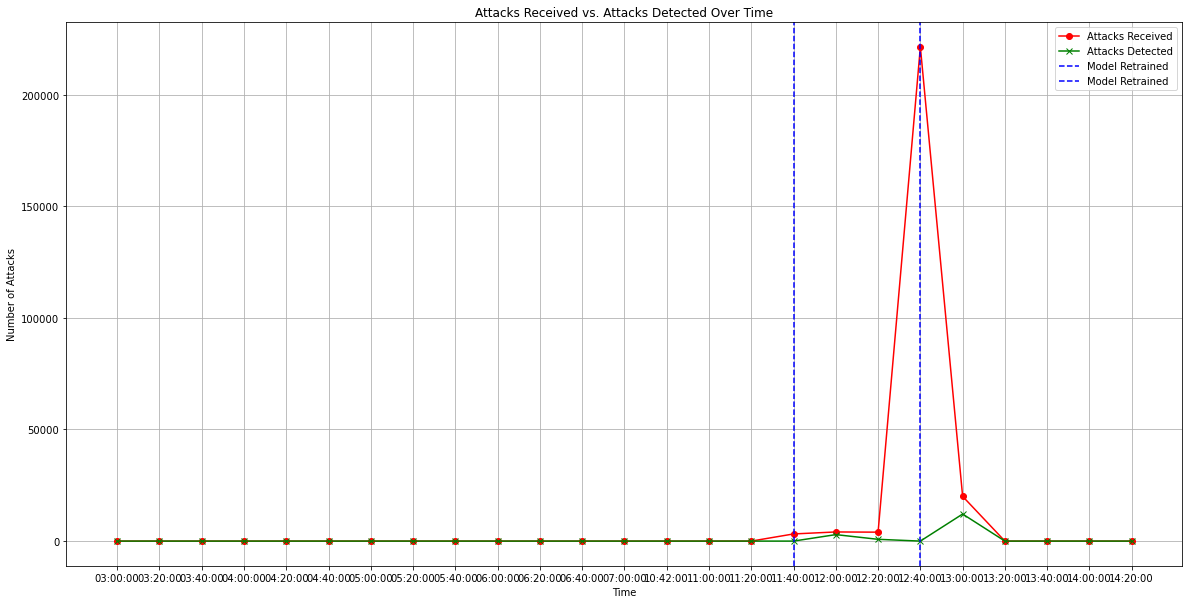

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Convertir a numpy arrays las listas involucradas
timestamps = np.array(metrics_df['timestamp'].tolist())

#TODO: esto está mal, vamos a calcularlo a partir de la matriz de confusión
attacks_received = np.array(metrics_df['true_negatives'] + metrics_df['false_negatives'])
attacks_detected = np.array(metrics_df['true_negatives'])

retrain_timestamps = np.array(metrics_df[metrics_df['retrained'] == True]['timestamp'].tolist())

# Crear el plot
plt.figure(figsize=(20, 10))

# Plot de ataques recibidos y detectados
plt.plot(timestamps, attacks_received, label='Attacks Received', color='red', marker='o')
plt.plot(timestamps, attacks_detected, label='Attacks Detected', color='green', marker='x')

# Añadir marcas donde se reentrenó el modelo
for retrain_time in retrain_timestamps:
    plt.axvline(x=retrain_time, color='blue', linestyle='--', label='Model Retrained')

plt.xlabel('Time')
plt.ylabel('Number of Attacks')
plt.title('Attacks Received vs. Attacks Detected Over Time')
plt.legend()
plt.grid(True)

# Guardar el plot como imagen
plt.savefig('attacks_detection_plot.png')

# Mostrar el plot
plt.show()


In [ ]:
#h2o.cluster().shutdown(prompt=False)

H2O session _sid_a22e closed.
